In [63]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")

In [64]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [65]:
train_data=pl.read_csv("train_errorAnalysed.csv")
test_data=pl.read_csv("test_errorAnalysed.csv")
train_data.shape,test_data.shape

((164, 13), (41, 13))

In [66]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

Test Scores: [0.45918176 0.95908397 0.74560438 0.88450178 0.80763992 0.94168529
 0.83179761 0.7921095  0.87699913 0.89144799 0.89748013 0.83422613
 0.94831046 0.89432891 0.85184839 0.72285341 0.65475607 0.64548075
 0.9682505  0.81309132 0.90874715 0.85556086 0.92693284 0.88248408
 0.76735213 0.95817321 0.72864514 0.88374592 0.92127888 0.82615616
 0.85636343 0.94071005 0.90649051 0.80065019 0.86664429 0.87352967
 0.90994453 0.94442149 0.91279019 0.95603841 0.88574346 0.89596203
 0.70103621 0.8743726  0.95706247 0.93363202 0.95795987 0.94059135
 0.88703715 0.69569032 0.66083569 0.48312751 0.94659049 0.96543889
 0.82253023 0.95257899 0.87277788 0.76932515 0.91329879 0.88533921
 0.85669186 0.91849172 0.76940172 0.85928967 0.90435272 0.87552756
 0.8644893  0.90231071 0.83414125 0.95362202 0.93266852 0.75031899
 0.92586216 0.81621155 0.88053048 0.74987517 0.80480446 0.90653938
 0.89525585 0.93573671 0.9363765  0.88693209 0.94599996 0.80862412
 0.83801288 0.95417978 0.95148005 0.78095559 0.84

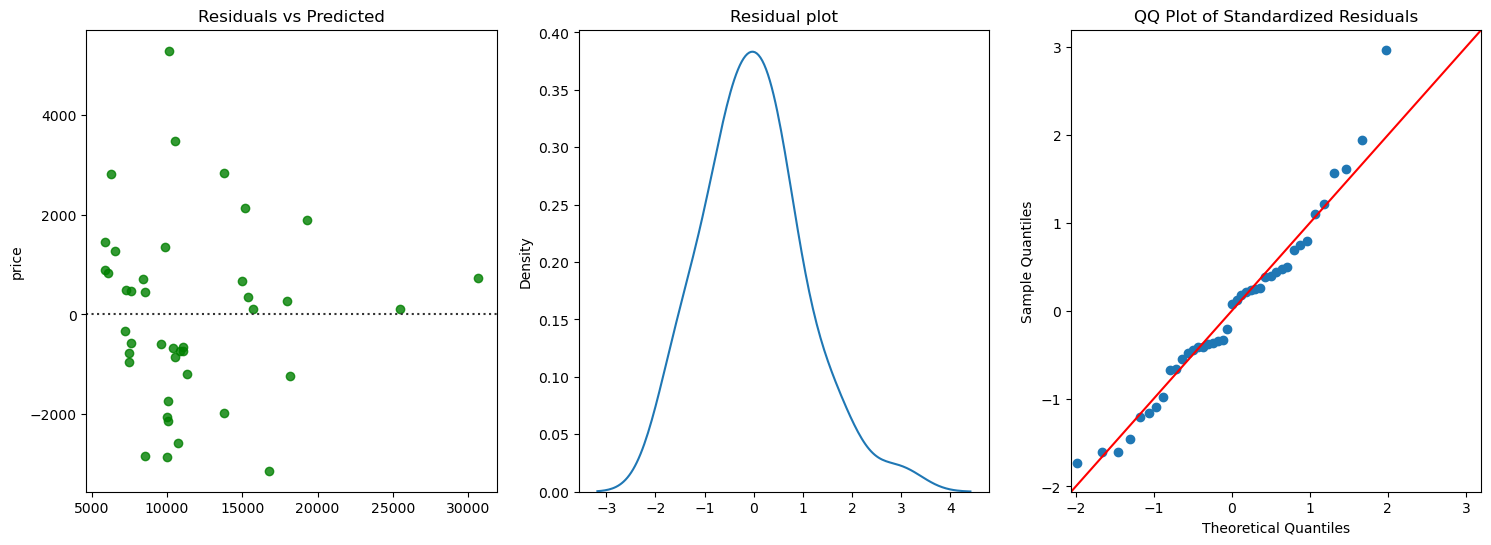

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,train_test_split,RepeatedKFold
import statsmodels.api as sm


imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",Lasso())
])

from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

In [68]:
threshold=np.std(residuals)*2

outliers=residuals[np.abs(residuals)>threshold]
outliers

1    5129.61968
Name: price, dtype: float64

In [69]:
test_data[[3,16]]

car_ID,aspiration,carbody,enginelocation,enginetype,fuelsystem,price,carclass,brandavg,carspace,averagempg,performancebalance,enginedisplacement
i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64
21,"""std""","""sedan""",0,"""ohc""","""2bbl""",6575.0,0.0,5723.0,954419.76,40.09816,89305.284254,1952.085407
104,"""std""","""sedan""",0,"""ohcv""","""mpfi""",13499.0,1.0,8124.0,1.2325e6,21.300448,344849.016902,6784.856616


# Lasso regression

Mean Absolute Error: 1501.320539400699
R-squared holdout: 0.8641637534846786


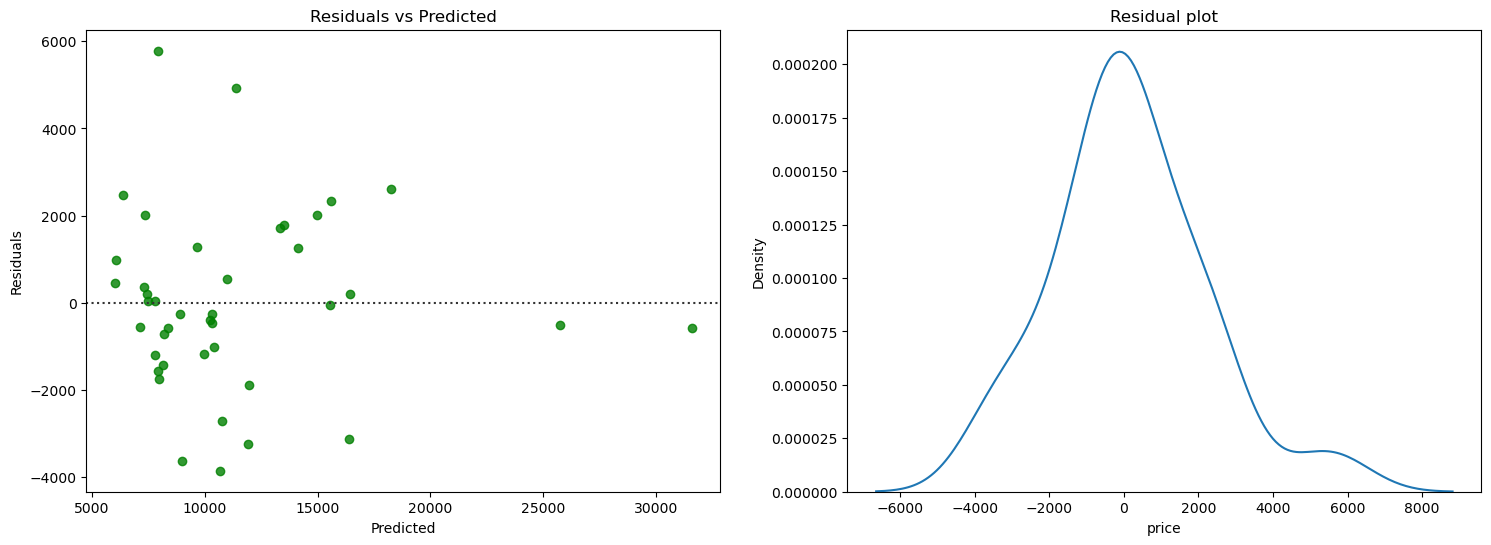

In [70]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,RepeatedKFold
lasso_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Lasso())
])
rkf=RepeatedKFold(n_splits=10,random_state=42)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(lasso_pipe, param_grid, cv=rkf,n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=rkf)

predictions = cross_val_predict(lasso_pipe, X_test, y_test)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Ridge regression

Mean Absolute Error: 1658.7153917767173
R-squared holdout: 0.8481847729129138


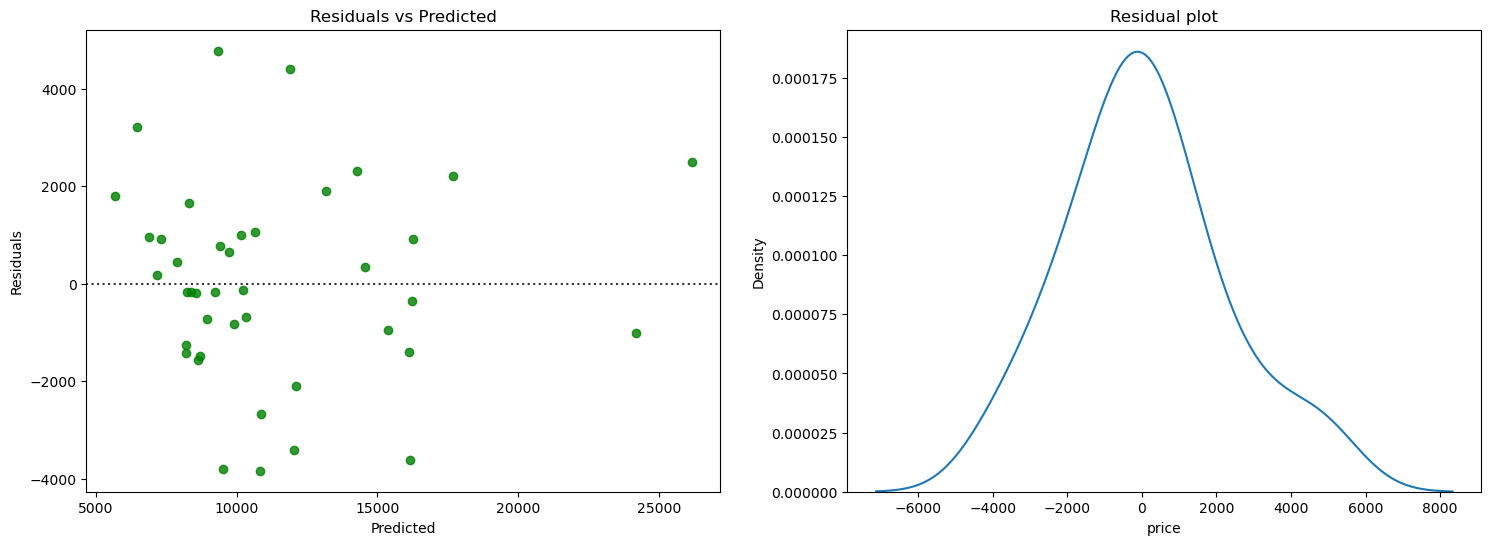

In [71]:
from sklearn.linear_model import Ridge
ridge_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Ridge())
])
rkf=RepeatedKFold(n_splits=10,random_state=42)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(ridge_pipe, param_grid, cv=rkf,n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=rkf)

predictions = cross_val_predict(ridge_pipe, X_test, y_test)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# All works same

Mean Absolute Error: 1375.8453243245895
R-squared holdout: 0.8866060957792783


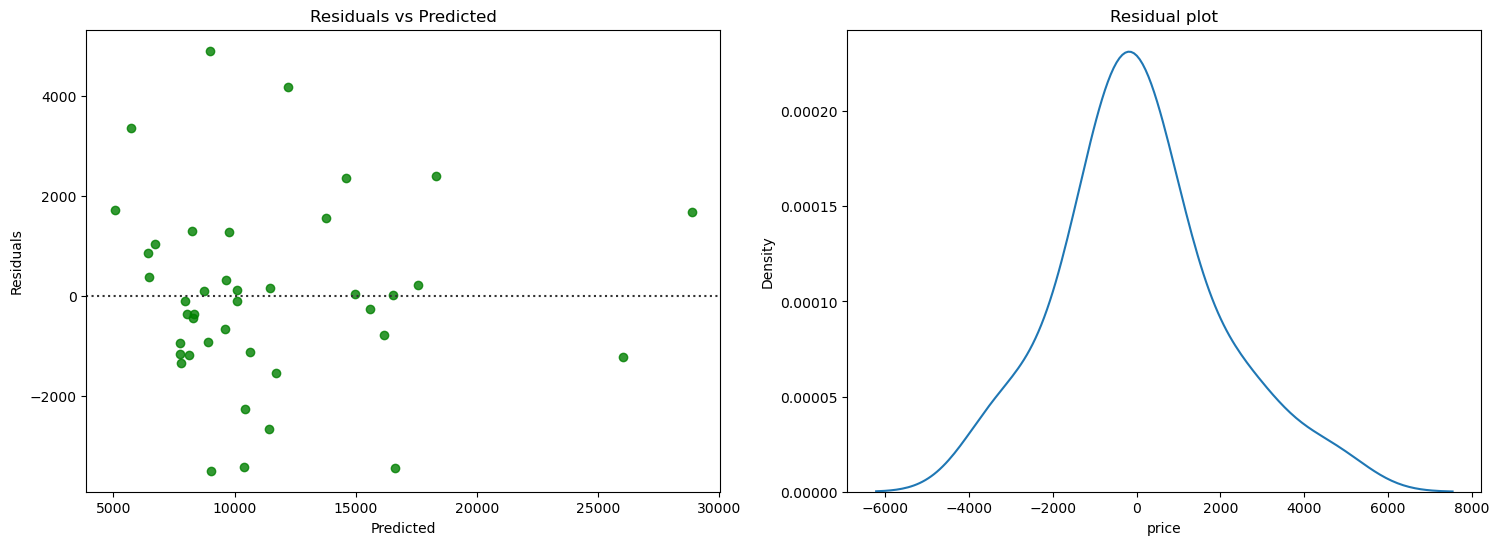

In [72]:
from sklearn.linear_model import ElasticNet

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100),
              'regressor__l1_ratio': np.arange(0.05,0.806,0.1)}
grid_search = GridSearchCV(elastic_pipe, param_grid, cv=rkf,n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']
best_l1_ratio = grid_search.best_params_['regressor__l1_ratio']
elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(elastic_pipe, X_train, y_train, cv=rkf)

predictions = cross_val_predict(elastic_pipe, X_test, y_test)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')

# Plotting residuals

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Elastic net regressor work better

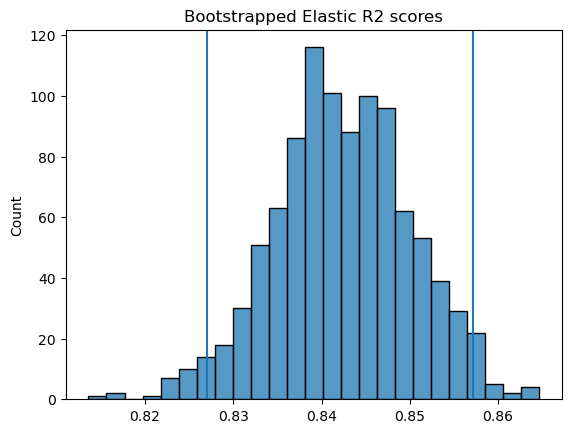

Mean Absolute Elasticnet Error: 2167.071565602777
Median Absolute Elasticnet Error: 2166.03105368741
Average Mean Elasticnet R-squared: 0.8422344941371307
Avg Median Elasticnet R-squared: 0.8593124594958332
95% Confidence Interval for R-squared: (0.8269805006412791, 0.8571328180227408)


In [73]:
def avg_elastic(X, y, num_iterations=100, num_bootstrap=1000):
    elastic_errors = []
    elastic_scores = []
    
    for i in range(num_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0 + i)
        kf = KFold(n_splits=3)
        
        elastic_pipe.fit(X_train, y_train)
        
        predictions = cross_val_predict(elastic_pipe, X_test, y_test, cv=kf)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        elastic_errors.append(mae)
        elastic_scores.append(r2)
        
    # Convert lists to numpy arrays for easier manipulation
    elastic_scores = np.array(elastic_scores)
    
    # Calculate the mean and median errors and scores
    mean_error = np.mean(elastic_errors)
    median_error = np.median(elastic_errors)
    mean_r2 = np.mean(elastic_scores)
    median_r2 = np.median(elastic_scores)
    
    # Bootstrap for confidence intervals
    bootstrapped_r2 = []
    n = len(elastic_scores)
    for _ in range(num_bootstrap):
        sample_indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample_r2 = elastic_scores[sample_indices]
        bootstrapped_r2.append(np.mean(sample_r2))
    
    lower_bound = np.percentile(bootstrapped_r2, 2.5)
    upper_bound = np.percentile(bootstrapped_r2, 97.5)
    sns.histplot(bootstrapped_r2)
    plt.title("Bootstrapped Elastic R2 scores")
    plt.axvline(lower_bound)
    plt.axvline(upper_bound)
    plt.show()
    return elastic_scores, mean_error, median_error, mean_r2, median_r2, lower_bound, upper_bound

# Assuming X and y are defined
elastic_scores, elastic_mae_mean, elastic_mae_median, elastic_r2_mean, elastic_r2_median, lower_bound, upper_bound = avg_elastic(X_train, y_train)

print(f'Mean Absolute Elasticnet Error: {elastic_mae_mean}')
print(f'Median Absolute Elasticnet Error: {elastic_mae_median}')
print(f'Average Mean Elasticnet R-squared: {elastic_r2_mean}')
print(f'Avg Median Elasticnet R-squared: {elastic_r2_median}')
print(f'95% Confidence Interval for R-squared: ({lower_bound}, {upper_bound})')

# Started absolute error : 4182
# End absolute error : 1535

### We still have some HeteroSkedacity due to nature of data (low scatter at low price and more at high price) ,we could cover those variance using some other regression techniques

### We still have Multicollinearity in the data